# Deeplearning Summer School 2020 - Final Project Group 4

**Group 4: Mantas, Lorenzo, Brian, Jona**

In the beginning each groupmember tried to read the dataset and run an existing model. 

The most efficient way was selected and a "collective" jupyter notebook was created. 

Each groupmember had still their own project and contributed the successful attempts to the collective notebook. 

After the exisitng model it was chosen to gridsearch custom parameters and crossvalidate the model to obtain the best generalization.

While this notebook contains the final parameters the model was trained locally on different PCs. This was done to reduce overall training time. Through splitting it was possible to achieve 36 h of training time on different models. 

The final chosen model was then retrained the full available dataset (2700/300). 

Then some test predictions were done on 4 images downloaded from the internet - these images were not used for further training or parameter tuning. 


## Task 1 - Defining problem and dataset

### Imports

In [225]:
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import seaborn as sns
import glob
import numpy as np 



from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from time import time
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

tf.compat.v1.disable_eager_execution()

### Inspecting dataset in directory 

In [129]:
directory = 'C:/Users/jonad/deeplearning/dataset'
print(os.listdir(directory))

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.1001.jpg', 'cat.1002.jpg', 'cat.1003.jpg', 'cat.1004.jpg', 'cat.1005.jpg', 'cat.1006.jpg', 'cat.1007.jpg', 'cat.1008.jpg', 'cat.1009.jpg', 'cat.101.jpg', 'cat.1010.jpg', 'cat.1011.jpg', 'cat.1012.jpg', 'cat.1013.jpg', 'cat.1014.jpg', 'cat.1015.jpg', 'cat.1016.jpg', 'cat.1017.jpg', 'cat.1018.jpg', 'cat.1019.jpg', 'cat.102.jpg', 'cat.1020.jpg', 'cat.1021.jpg', 'cat.1022.jpg', 'cat.1023.jpg', 'cat.1024.jpg', 'cat.1025.jpg', 'cat.1026.jpg', 'cat.1027.jpg', 'cat.1028.jpg', 'cat.1029.jpg', 'cat.103.jpg', 'cat.1030.jpg', 'cat.1031.jpg', 'cat.1032.jpg', 'cat.1033.jpg', 'cat.1034.jpg', 'cat.1035.jpg', 'cat.1036.jpg', 'cat.1037.jpg', 'cat.1038.jpg', 'cat.1039.jpg', 'cat.104.jpg', 'cat.1040.jpg', 'cat.1041.jpg', 'cat.1042.jpg', 'cat.1043.jpg', 'cat.1044.jpg', 'cat.1045.jpg', 'cat.1046.jpg', 'cat.1047.jpg', 'cat.1048.jpg', 'cat.1049.jpg', 'cat.105.jpg', 'cat.1050.jpg', 'cat.1051.jpg', 'cat.1052.jpg', 'cat.1053.jpg', 'cat.

### Loading Dataset into dataframes 

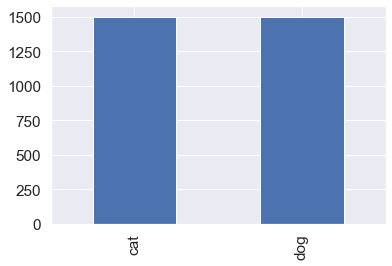

In [130]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

filenames = os.listdir(directory)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
df['category'].value_counts().plot.bar()



## Task 2 - Creating the datagenerators 

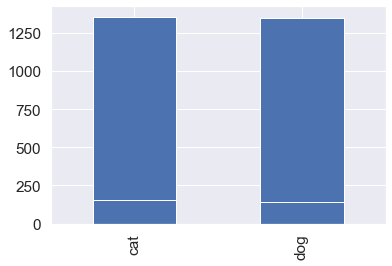

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [131]:
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df['category'].value_counts().plot.bar()
test_df['category'].value_counts().plot.bar()
plt.show()

total_train = train_df.shape[0]
# total_validate = validate_df.shape[0]
batch_size = 5

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



### Visualizing a random sample from the dataset (without augmentation) 

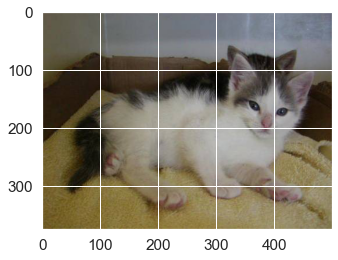

In [132]:
sample = random.choice(filenames)
image = load_img(directory + "/" + sample)
plt.imshow(image)


### Visualizing the data augmentation 

Found 1 validated image filenames belonging to 1 classes.


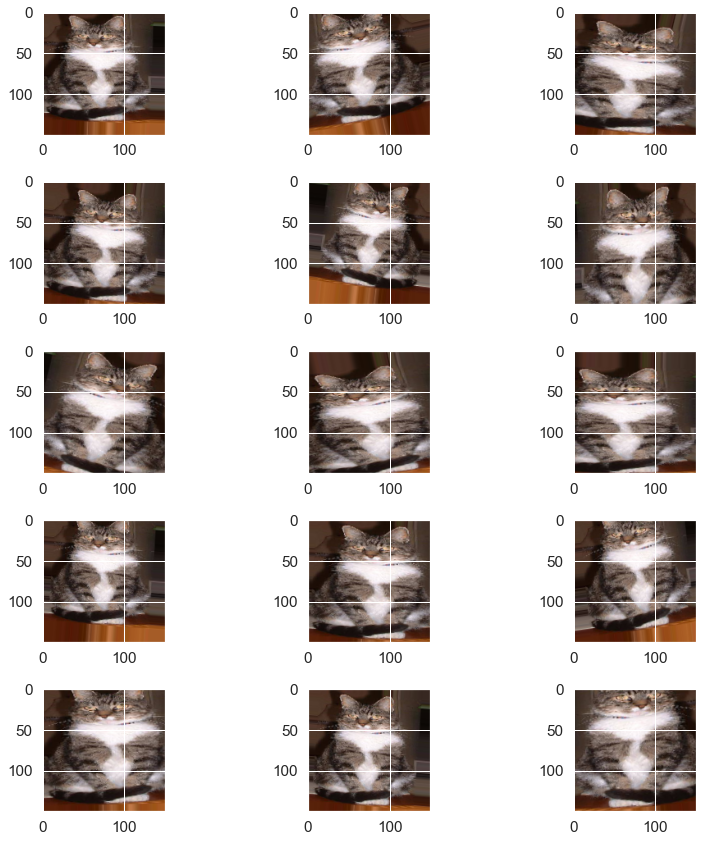

In [133]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i + 1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## (Using an existing network structure - resnet(?) )
Just trying to replicate ResNet structure with skiping layers

In [ ]:
inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    
x = Conv2D(64, (7, 7), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))(inputs)
x_temp = x
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Add()([x, x_temp])
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Add()([x, x_temp])
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Add()([x, x_temp])
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)

x = MaxPooling2D(pool_size=(5, 5))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x) # 2 because we have cat and dog classes

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(
    train_generator, 
    epochs=10,
    )

_, acc = model.evaluate(test_generator)

### Intermediate results from resnet 
Loading and visualizing the intermediate results. As we can see only 4 blocks of ResNet do not work correctly with our data

In [136]:
path = r'C:\Users\jonad\deeplearning\results\resnet.csv'

frame3 = pd.read_csv(path, index_col=None, header=0)
frame3

,Unnamed: 0,Structure,AVG Train,AVG Valid,AVG Test,Time
0,0,resnet,0.506296,0.485556,0.505556,449.296817


## Task 3 - Constructing the network

In [137]:
def define_model(
        nodes=16,
        loss='binary_crossentropy',
        opt="rmsprop",
        pooling="MAX",
        dropout=False,
        fc=1,
        act="relu",
        blocks=0,
        filters_no = 64,
        padding = "same",
        kernel_size = (3,3),
        pool_size= (5,5),
        dropout_prob = 0.2):

    inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

    x = Conv2D(filters_no, kernel_size, activation=act, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))(inputs)

    for _ in range(0, blocks):
        x = Conv2D(filters_no, kernel_size, padding=padding, activation=act)(x)
        x = BatchNormalization()(x)
        if pooling == "MAX":
            x = MaxPooling2D(pool_size=pool_size)(x)
        if pooling == "AVG":
            x = AveragePooling2D(pool_size=(2, 2))(x)
        if dropout:
            x = Dropout(dropout_prob)(x)

    x = Flatten()(x)

    for _ in range(0, fc):
        x = Dense(nodes, activation=act)(x)

    if dropout:
        x = Dropout(dropout_prob)(x)

    x = BatchNormalization()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

    return model

### Establishing callbacks 

In [138]:
earlystop = EarlyStopping(patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

### Specifying parameters for Gridsearch 

In [139]:
# Parameters for grid search

# CYCLE PARAMETERS
n_folds = 3  # Number of folds for K-fold CV
epochs = 20  # Number for model training epochs
batch = 5  # Batch size of the training

# CNN PARAMETERS
blocks = [2]  # Number of blocks (Conv2D + Pooling layers) in the model, by default 2
nodes = [512]  # List of the number of nodes for the gridseach
fcs = [2]  # List of the number of fully connected layers after Flatten in the model
acts = ["tanh"]  # List of activation functions used in the model
poolings = ["MAX"]  # List of poolings used in the model (Available options: MAX, AVG)
opts = ["sgd"]  # List of optimizers used in the model
# structure = "cnn"
kernel_sizes =[(3,3)] # Format to enter (3,3) 
pool_sizes = [(5,5)] # Format to enter (5,5) 
drop_probs = [0.2] # Format to enter 0.2
paddings = ["valid"] # Available choose between same and valid
filters = [128] # Numbers of filters Best results were obtained with 128 filters

# AUGMENTATION PARAMETERS
rotations = [0,15]
shears = [0, 0.1]
zooms = [0, 0.2]
flips = [True]
wsrs = [0, 0.1]
hsrs = [0, 0.1]
zcas = [True, False]

information = True  # If True print completed model parameters and average accuracy for folds

### Creating a dataframe to hold the results 

In [140]:
# Prepare DataFrame for results saving
Results = pd.DataFrame(columns=["Optimizer","Pooling", "Fully Connected", "Activation", "Blocks",
                                "Filters","Padding","Kernel Size","Pool Size","Node", "Rotation","Shear",
                                "Zoom","Flip","WSR","HSR","ZCA", "AVG Train",
                                "AVG Valid", "AVG Test", "Time"])

### Initializing k-fold CV 

In [141]:
# K-Fold CV
# prepare cross validation
kfold = KFold(n_folds, shuffle=True, random_state=1)
splits = kfold.split(train_df)

### Training Phase: k-fold & gridsearch 

In [ ]:
total_models = len(opts)*len(poolings)*len(fcs)*\
len(acts)*len(blocks)*len(filters)*len(paddings)*\
len(kernel_sizes)*len(pool_sizes)*len(drop_probs)*\
len(nodes)*len(rotations)*len(shears)*len(flips)*\
len(wsrs)*len(hsrs)*len(zcas)

model_no=1

# CNN GridSearch LOOPS
for o in opts:
    for pool in poolings:
        for fc in fcs:
            for act in acts:
                for block in blocks:
                    for filters_no in filters:
                        for pad in paddings:
                            for ks in kernel_sizes:
                                for ps in pool_sizes:
                                    for dp in drop_probs:
                                        for n in nodes:
                                            
                                            # DATA AUGMENTATION LOOPS
                                            for rotate in rotations:
                                                for shear in shears:
                                                    for zoom in zooms:
                                                        for flip in flips:
                                                            for wsr in wsrs:
                                                                for hsr in hsrs:
                                                                    for zca in zcas:
                                                                        start = time()
                                                                        avg_train_acc = 0
                                                                        avg_val_acc = 0
                                                                        avg_test_acc = 0

                                                                        print("*******************************************************************")
                                                                        print(f"Model {model_no} out of {total_models} started")
                                                                        print("*******************************************************************")


                                                                        train_datagen = ImageDataGenerator(
                                                                            rotation_range=rotate,
                                                                            rescale=1./255,
                                                                            shear_range=shear,
                                                                            zoom_range=zoom,
                                                                            horizontal_flip=flip,
                                                                            width_shift_range=wsr,
                                                                            height_shift_range=hsr,
                                                                            zca_whitening = zca
                                                                        )

                                                                        for train_ix, test_ix in kfold.split(train_df):

                                                                            model = define_model(
                                                                                nodes=n,
                                                                                loss='binary_crossentropy',
                                                                                opt=o,
                                                                                pooling=pool,
                                                                                dropout=False,
                                                                                fc=fc,
                                                                                act=act,
                                                                                blocks=block,
                                                                                filters_no = filters_no,
                                                                                padding = pad,
                                                                                kernel_size = ks,
                                                                                pool_size= ps,
                                                                                dropout_prob = dp)

                                                                            train_generator = train_datagen.flow_from_dataframe(
                                                                                train_df.iloc[train_ix],
                                                                                directory,
                                                                                x_col='filename',
                                                                                y_col='category',
                                                                                target_size=IMAGE_SIZE,
                                                                                class_mode='categorical',
                                                                                batch_size=batch_size
                                                                            )

                                                                            validation_generator = train_datagen.flow_from_dataframe(
                                                                                train_df.iloc[test_ix],
                                                                                directory,
                                                                                x_col='filename',
                                                                                y_col='category',
                                                                                target_size=IMAGE_SIZE,
                                                                                class_mode='categorical',
                                                                                batch_size=batch_size
                                                                            )

                                                                            history = model.fit(
                                                                                train_generator,
                                                                                verbose=2,
                                                                                epochs=epochs,
                                                                                validation_data=validation_generator,
                                                                                callbacks=callbacks
                                                                            )

                                                                            _, acc = model.evaluate(train_generator)
                                                                            print(f"Training Acc: {acc}")
                                                                            avg_train_acc = avg_train_acc + acc

                                                                            _, acc = model.evaluate(validation_generator)
                                                                            print(f"Validation Acc: {acc}")
                                                                            avg_val_acc = avg_val_acc + acc

                                                                            _, acc = model.evaluate(test_generator)
                                                                            print(f"Test Acc: {acc}")
                                                                            avg_test_acc = avg_test_acc + acc

                                                                            K.clear_session()
                                                                            gc.collect()
                                                                            
                                                                        model_no=model_no+1

                                                                        Results = Results.append({"Optimizer": o,
                                                                                                  "Pooling" : pool,
                                                                                                  "Fully Connected": fc,
                                                                                                  "Activation": act,
                                                                                                  "Blocks": block,
                                                                                                  "Filters": filters_no,
                                                                                                  "Padding": pad,
                                                                                                  "Kernel Size": ks,
                                                                                                  "Pool Size": ps,
                                                                                                  "Node": n,
                                                                                                  "Rotation": rotate,
                                                                                                  "Shear": shear,
                                                                                                  "Zoom": zoom,
                                                                                                  "Flip": flip,
                                                                                                  "WSR": wsr,
                                                                                                  "HSR": hsr,
                                                                                                  "ZCA": zca,
                                                                                                  "AVG Train": avg_train_acc / n_folds,
                                                                                                  "AVG Valid": avg_val_acc / n_folds,
                                                                                                  "AVG Test": avg_test_acc / n_folds,
                                                                                                  "Time": time() - start},
                                                                                                 ignore_index=True)

### Saving the results externally 

In [143]:
Results.to_csv("results/model_params.csv")

### Visualizing the differences to cnn and resnet default 

Explain here the conclusion we have drawn from the different attempts 

### Visualizing intermediate results from the csv file 
for efficiency reasons we decided to iterate the model in seperate steps on seperate group members pcs 
we then merged multiple csv files into one

In [144]:
path = r'C:\Users\jonad\deeplearning\results' # use your path
all_files = glob.glob(path + "/p-*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame['Model'] = np.arange(1, len(frame)+1)
total_time_h = (frame["Time"].sum())/3600
frame.to_csv(r'C:\Users\jonad\deeplearning\results\all_models.csv', index = False)
frame

,Unnamed: 0,Optimizer,Fully Connected,Activation,Blocks,Node,AVG Train,AVG Valid,AVG Test,Time,Filters,Model
0,0,sgd,2,sigmoid,1,512,0.500000,0.501852,0.494444,269.852197,NaN,1
1,1,sgd,2,sigmoid,1,1024,0.508148,0.485556,0.494444,297.009147,NaN,2
2,2,sgd,2,tanh,1,512,0.706111,0.700741,0.702222,362.609535,NaN,3
3,3,sgd,2,tanh,1,1024,0.703889,0.697037,0.695556,365.658987,NaN,4
4,4,sgd,2,relu,1,512,0.678889,0.678889,0.675556,365.334030,NaN,5
5,5,sgd,2,relu,1,1024,0.674444,0.671481,0.657778,365.301828,NaN,6
6,0,sgd,2,tanh,1,256,0.685556,0.676667,0.695556,369.017858,NaN,7
7,1,sgd,2,tanh,1,512,0.702222,0.687407,0.707778,364.759619,NaN,8
8,2,sgd,2,tanh,2,256,0.739444,0.722593,0.752222,366.970545,NaN,9
9,3,sgd,2,tanh,2,512,0.744630,0.721481,0.747778,366.826438,NaN,10


### Total training time 

In [269]:
path = r'C:\Users\jonad\deeplearning\results' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame_total = pd.concat(li, axis=0, ignore_index=True)

total_time_h = (frame_total["Time"].sum())/3600
print("Total training time is:",total_time_h,  "hours")

Total training time is: 36.433965069452924 hours


In [146]:
frame[frame['AVG Test']==frame['AVG Test'].max()]

,Unnamed: 0,Optimizer,Fully Connected,Activation,Blocks,Node,AVG Train,AVG Valid,AVG Test,Time,Filters,Model
27,3,sgd,2,tanh,1,1000,0.827037,0.79,0.803333,1973.54202,128.0,28


### Changing parameters iteration 1 
the parameters above where obtained with 8 epochs. we tried with the same parameters but more epochs (50) to utilize the early stopping. 

In [147]:
path = r'C:\Users\jonad\deeplearning\results\sgd_tanh_512_50epochs_3folds.csv' 

frame2 = pd.read_csv(path, index_col=None, header=0)
frame2

,Unnamed: 0,Optimizer,Fully Connected,Activation,Blocks,Node,AVG Train,AVG Valid,AVG Test,Time
0,0,sgd,2,tanh,1,512,0.725926,0.704444,0.715556,687.401647


### Changing parameters iteration 2
the following results were then obtained by setting the epochs down to 25 since early stopping always stopped at around 25 epochs. the number of folds was increased from 3 to 5 

In [148]:
path = r'C:\Users\jonad\deeplearning\results\sgd_tanh_512_25epochs_5folds.csv' # use your path

frame3 = pd.read_csv(path, index_col=None, header=0)
frame3

,Unnamed: 0,Optimizer,Fully Connected,Activation,Blocks,Node,AVG Train,AVG Valid,AVG Test,Time
0,0,sgd,2,tanh,1,512,0.720556,0.716667,0.736,1117.514087


### Changing parameters iteration 3
parameters were changed to 25 epochs and 5 folds, early stopping patience = 3

In [149]:
path = r'C:\Users\jonad\deeplearning\results\sdg_tanh_512_25epochs_5folders_2blocks.csv' # use your path

frame4 = pd.read_csv(path, index_col=None, header=0)
frame4

,Unnamed: 0,Optimizer,Fully Connected,Activation,Blocks,Node,AVG Train,AVG Valid,AVG Test,Time
0,0,sgd,2,tanh,2,512,0.803056,0.778148,0.812667,1128.798761


### Making it fancy with seaborn

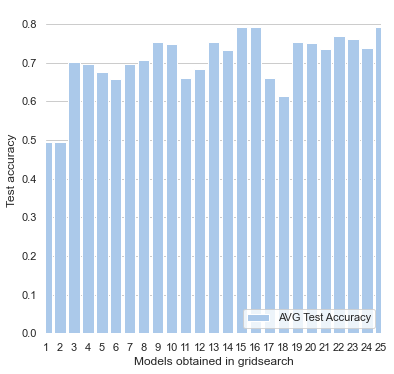

In [150]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))


# plot the average test accuracy for the corresponding models 
sns.set_color_codes("pastel")
sns.barplot(x="Model", y="AVG Test", data=frame,
            label="AVG Test Accuracy", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="Test accuracy",
       xlabel="Models obtained in gridsearch")
sns.despine(left=True, bottom=True)

In [151]:
new = pd.melt(frame, id_vars=['Model', 'Optimizer', 'Fully Connected','Activation', 'Blocks', 'Node', 'AVG Train', 'AVG Valid'], value_vars=['AVG Test'])

In [152]:
new_sort = new.sort_values(by='value', ascending=False)
new_sort

,Model,Optimizer,Fully Connected,Activation,Blocks,Node,AVG Train,AVG Valid,variable,value
27,28,sgd,2,tanh,1,1000,0.827037,0.790000,AVG Test,0.803333
26,27,sgd,2,tanh,1,512,0.820926,0.769259,AVG Test,0.801111
25,26,sgd,2,tanh,1,1000,0.802963,0.768889,AVG Test,0.794444
15,16,sgd,2,relu,2,1000,0.779444,0.747407,AVG Test,0.792222
24,25,sgd,2,tanh,1,512,0.805926,0.769630,AVG Test,0.791111
14,15,sgd,2,relu,2,512,0.785185,0.772222,AVG Test,0.791111
21,22,sgd,2,relu,1,1000,0.829444,0.763333,AVG Test,0.767778
22,23,sgd,2,relu,1,512,0.789444,0.748519,AVG Test,0.762222
12,13,sgd,2,relu,1,512,0.799444,0.755926,AVG Test,0.754444
18,19,sgd,2,relu,1,512,0.781296,0.744815,AVG Test,0.752222


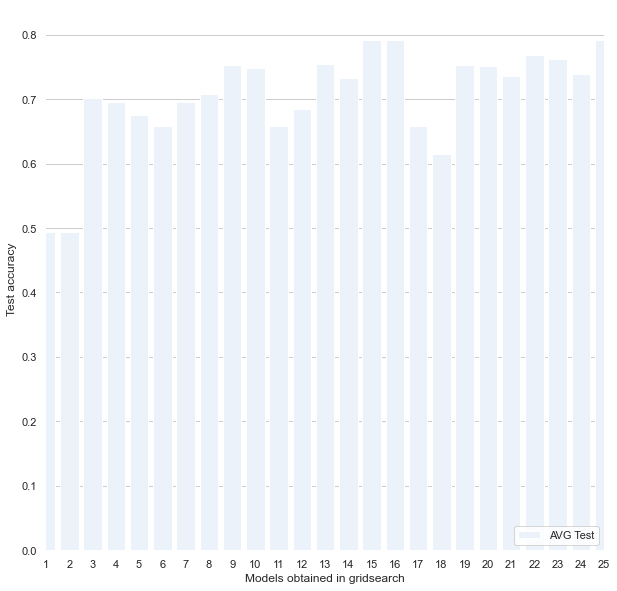

In [153]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))


# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Model", y="value", data=new,
            hue='variable', 
            color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="Test accuracy",
       xlabel="Models obtained in gridsearch")
sns.despine(left=True, bottom=True)

### Changing Parameters 4 

In [228]:
path = r'C:\Users\jonad\deeplearning\results\formatted_grid_search.csv' 
gridsearch = pd.read_csv(path, index_col=None, header=0)
gridsearch['Model'] = np.arange(1, len(gridsearch)+1)
gridsearch

,Unnamed: 0,Filters,Pool Sizes,Dropout,Dropout Value,AVG Train,AVG Valid,AVG Test,Time,Model
0,0,128,"(3, 3)",True,0.2,NaN,0.719630,0.760000,407.046849,1
1,1,128,"(3, 3)",True,0.5,NaN,0.705185,0.733333,403.401947,2
2,2,128,"(3, 3)",False,0.2,NaN,0.712963,0.748889,404.307512,3
3,3,128,"(3, 3)",False,0.5,NaN,0.717778,0.741111,404.275874,4
4,4,128,"(5, 5)",True,0.2,NaN,0.739259,0.738889,402.945276,5
5,5,128,"(5, 5)",True,0.5,NaN,0.745556,0.743333,402.909901,6
6,6,128,"(5, 5)",False,0.2,NaN,0.728889,0.766667,403.021736,7
7,7,128,"(5, 5)",False,0.5,NaN,0.739259,0.755556,403.599506,8
8,8,128,"(7, 7)",True,0.2,NaN,0.667407,0.681111,403.192519,9
9,9,128,"(7, 7)",True,0.5,NaN,0.679259,0.714444,404.164485,10


Above was tested with differnet filter numbers - more filters didnt yield a much better result, but caused a much longer training time therefore it was decided to use 128 filters 

on average a (5,5) pool size gave the best results  

it was also decided not to use dropout layers 

### Data Augmentation Impact on Test Accuracy

In [170]:
path = r'C:\Users\jonad\deeplearning\results\augmentation_results.csv' 
augmentation = pd.read_csv(path, index_col=None, header=0)
augmentation['Model'] = np.arange(1, len(augmentation)+1)
augmentation

,Unnamed: 0,Optimizer,Pooling,Fully Connected,Activation,Blocks,Filters,Padding,Kernel Size,Pool Size,...,Zoom,Flip,WSR,HSR,ZCA,AVG Train,AVG Valid,AVG Test,Time,Model
0,0,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.0,0.0,True,0.965741,0.797407,0.822222,694.005402,1
1,1,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.0,0.0,False,0.959630,0.789630,0.806667,537.183526,2
2,2,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.0,0.1,True,0.872222,0.798148,0.811111,910.628136,3
3,3,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.0,0.1,False,0.856296,0.787778,0.805556,918.775386,4
4,4,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.1,0.0,True,0.873333,0.798518,0.813333,899.652251,5
5,5,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.1,0.0,False,0.880741,0.801481,0.808889,900.545044,6
6,6,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.1,0.1,True,0.803519,0.779259,0.790000,905.515128,7
7,7,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.0,True,0.1,0.1,False,0.825556,0.791111,0.805556,903.464653,8
8,8,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.2,True,0.0,0.0,True,0.869074,0.789259,0.814444,901.522304,9
9,9,sgd,MAX,2,tanh,2,128,valid,"(3, 3)","(5, 5)",...,0.2,True,0.0,0.0,False,0.843889,0.779259,0.801111,908.531949,10


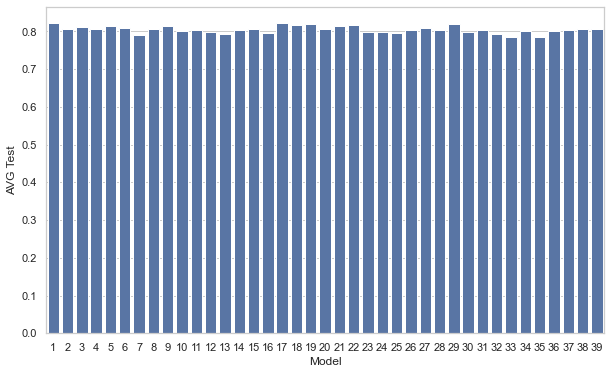

In [171]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# plot the average test accuracy for the corresponding models 
sns.barplot(x="Model", y="AVG Test", data=augmentation,
            label="AVG Test Accuracy", color="b")

CONCLUSIONS OF DATA AUGMENTATION:
Without any augmentation training accuracy can be achieved even 95,9 % but a model like that validation and testing accuracy just around 80 %. That means without data augmentation we have huge overfitting.
• Rotation - By increasing rotation parameter average training accuracy in fold drop to 87 % but for test and validation stays the same, that shows that chance of overfitting is reduced
• Shear - also impact in the same way as rotation but training accuracy drop is not that high, and we can see that shear increased our testing accuracy
• Zoom - this one data augmentation also decreased training accuracy but didn't impact test accuracy
• Flip - Same way as others
• Width shift - Same way as others
• Height shift - Same way as others
• ZCA Whitening - no big impact on training accuracy but have an impact on test accuracy. Using this one whitening test accuracy have been increased by around 2 %

The best results were achieved using all of this augmentation but no rotation

### Retraining the model 

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=0,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zca_whitening=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# CYCLE PARAMETERS
epochs = 50  # Number for model training epochs
batch = 5  # Batch size of the training

model = define_model(
    nodes=512,
    loss='binary_crossentropy',
    opt='sgd',
    pooling='MAX',
    fc=2,
    act='tanh',
    blocks=2,
    filters_no=128,
    padding="valid",
    kernel_size=(3, 3),
    dropout=False,
    pool_size=(5, 5),
    dropout_prob=0.2
)


history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks
)

, acc = model.evaluate(test_generator)

history_dict = history.history
history_df = pd.DataFrame({'loss': history_dict['loss'], 'accuracy': history_dict['accuracy'],
                           'val_loss': history_dict['val_loss'], 'val_accuracy': history_dict['val_accuracy']})

history_df.to_csv('history.csv')


### Saving the model 

In [ ]:
model.save("models/final.h5")

## Task 4 - Visualizing our results 

#### Loading the model 
Loading a trained model as it was trained on a different pc 

In [253]:
model = tf.keras.models.load_model('C:/Users/jonad/deeplearning/final50epochs.h5')

### Visualizing the Confusion matrix

In [254]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[75 80]
 [60 85]]
Classification Report
              precision    recall  f1-score   support

        Cats       0.56      0.48      0.52       155
        Dogs       0.52      0.59      0.55       145

    accuracy                           0.53       300
   macro avg       0.54      0.54      0.53       300
weighted avg       0.54      0.53      0.53       300



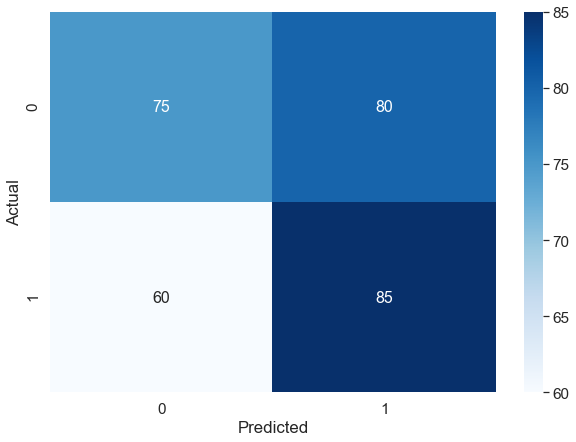

In [255]:
data = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(test_generator.classes), index = np.unique(test_generator.classes))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Visualizing the wrongly classified images 

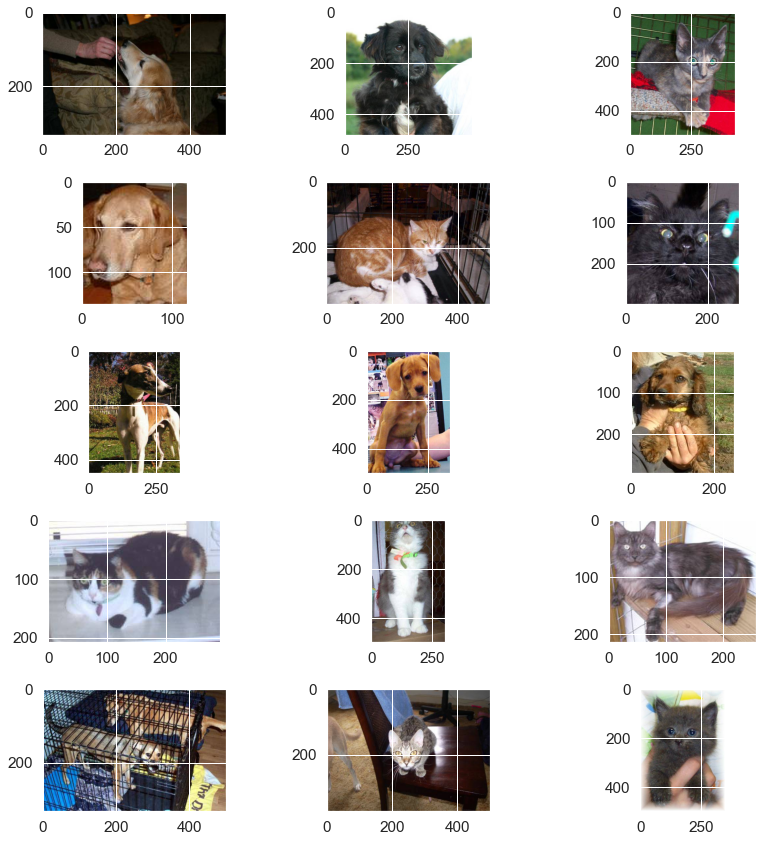

In [256]:
incorrects = np.nonzero(y_pred.reshape((-1,)) != test_generator.classes)
incorrects
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    sample = test_df.iloc[incorrects[0][i]]["filename"]
    image = load_img(directory+"/"+sample)
    plt.imshow(image)
plt.tight_layout()
plt.show()

### Loading the model.fit history from external .csv file 

In [257]:
history_df = pd.read_csv('C:/Users/jonad/deeplearning/history50.csv')
history_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,0.678516,0.568148,0.643834,0.610000
1,1,0.632362,0.652963,0.588320,0.716667
2,2,0.588810,0.685556,0.573288,0.700000
3,3,0.561713,0.703333,0.520370,0.756667
4,4,0.538006,0.724074,0.512323,0.760000
5,5,0.524242,0.748519,0.522435,0.756667
6,6,0.514535,0.757037,0.474556,0.793333
7,7,0.493734,0.760000,0.624889,0.706667
8,8,0.480374,0.768889,0.501832,0.770000
9,9,0.469706,0.782593,0.443280,0.813333


### Visualizing training and validation accuracy ( 50 epochs with early stopping) 

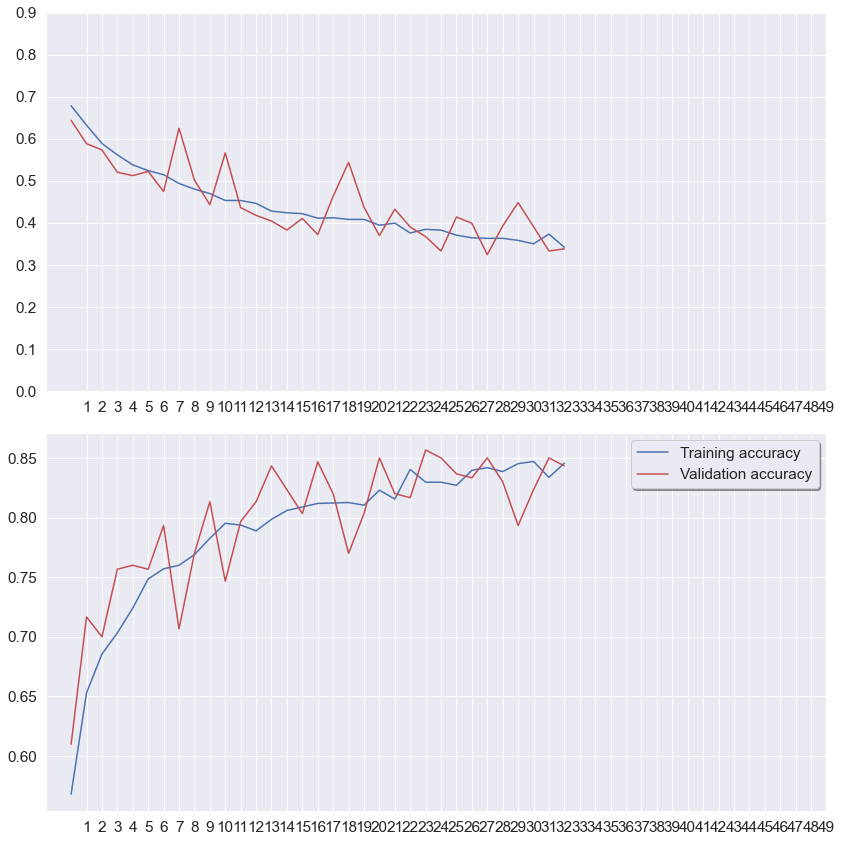

In [258]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history_df['loss'], color='b', label="Training loss")
ax1.plot(history_df['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_df['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_df['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Testing predictions

Probabilities: [[1.7255872e-04 9.9982738e-01]]
DOG!


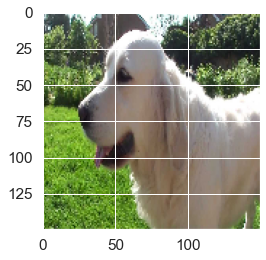

In [265]:
# predicting images
img = tf.keras.preprocessing.image.load_img('C:/Users/jonad/deeplearning/testdog.jpg', target_size=(150, 150))

x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")
plt.imshow(img)

Probabilities: [[0.9867662  0.01323384]]
CAT!


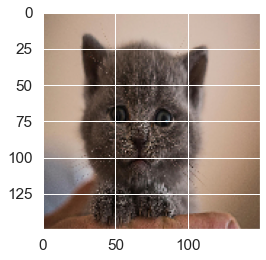

In [266]:
img2 = tf.keras.preprocessing.image.load_img('C:/Users/jonad/deeplearning/testcat.jpg', target_size=(150, 150))
x = tf.keras.preprocessing.image.img_to_array(img2)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")
    
plt.imshow(img2)

Probabilities: [[0.01110334 0.9888967 ]]
DOG!


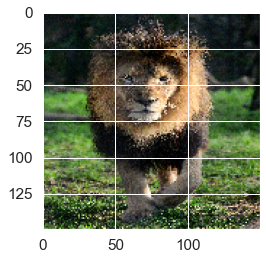

In [267]:
img3 = tf.keras.preprocessing.image.load_img('C:/Users/jonad/deeplearning/testlion.jpg', target_size=(150, 150))
x = tf.keras.preprocessing.image.img_to_array(img3)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")
    
plt.imshow(img3)

Probabilities: [[0.4756793  0.52432066]]
DOG!


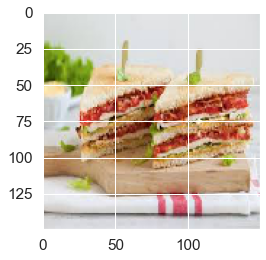

In [268]:
img4 = tf.keras.preprocessing.image.load_img('C:/Users/jonad/deeplearning/testsandwich.jpg', target_size=(150, 150))
x = tf.keras.preprocessing.image.img_to_array(img4)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")
    
plt.imshow(img4)

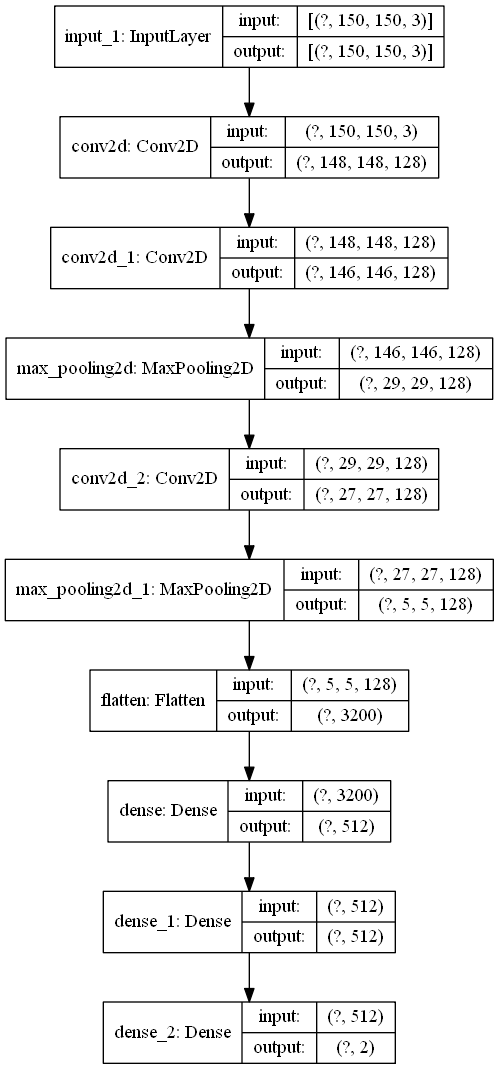

In [263]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn.png' ,show_shapes=True, show_layer_names=True)